In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [2]:
with open("../Data/simu2_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)

In [3]:
# df_study = df_study.loc[df_study.session < 5]
df_study

,itemno,item,freq,session
0,552,FARM,1161,0
1,812,LEOPARD,118,0
2,741,INSTRUCTOR,78,0
3,153,BOTTLE,1479,0
4,150,BOOT,149,0
...,...,...,...,...
99995,1491,TOWN,3328,999
99996,1057,PIANO,466,999
99997,1398,SUBMARINE,154,999
99998,791,LABYRINTH,32,999


In [4]:
# df_test = df_test.loc[df_test.session < 200]
df_test

,itemno,item,freq,session,old
0,595,FORT,411,0,True
1,864,MANSION,156,0,True
2,121,BENCH,345,0,True
3,667,GUARD,658,0,False
4,112,BEE,185,0,True
...,...,...,...,...,...
199995,850,LUNG,169,999,True
199996,1485,TORNADO,34,999,False
199997,1553,VEHICLE,383,999,False
199998,1215,RUG,321,999,True


### Run CMR-IA

In [5]:
s_mat = np.loadtxt('../Data/wordpools/w2v.txt')
s_mat.shape

(1638, 1638)

In [6]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.635,
    beta_rec = 0.5,
    beta_rec_post = 0.888,
    gamma_fc = 0.432,
    s_fc = 0.423,
    c_thresh = 0.577,
    a = 2800,
    b = 2.14
)
params

{'beta_enc': 0.635,
 'beta_rec': 0.5,
 'beta_rec_post': 0.888,
 'beta_distract': None,
 'phi_s': 2,
 'phi_d': 0.5,
 's_cf': 0,
 's_fc': 0.423,
 'kappa': 0.5,
 'eta': 0.5,
 'omega': 8,
 'alpha': 4,
 'c_thresh': 0.577,
 'lamb': 0.5,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 50,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'gamma_fc': 0.432,
 'gamma_cf': 0.5}

In [7]:
df_simu = cmr.run_norm_recog_multi_sess(params,df_study,df_test,s_mat)
df_simu

CMR Time: 44.65017247200012


,session,itemno,s_resp,s_rt,csim
0,0,595,0.0,1415.115356,0.258118
1,0,864,0.0,2554.847168,0.534184
2,0,121,0.0,2423.887207,0.509595
3,0,667,0.0,2010.428223,0.422200
4,0,112,0.0,2730.358154,0.565231
...,...,...,...,...,...
199995,999,850,1.0,2627.942871,0.606635
199996,999,1485,0.0,2178.174561,0.459648
199997,999,1553,0.0,2666.063965,0.554095
199998,999,1215,1.0,2633.304443,0.605682


In [8]:
df_simu = df_simu.merge(df_test,on=['session','itemno'])
df_simu

,session,itemno,s_resp,s_rt,csim,item,freq,old
0,0,595,0.0,1415.115356,0.258118,FORT,411,True
1,0,864,0.0,2554.847168,0.534184,MANSION,156,True
2,0,121,0.0,2423.887207,0.509595,BENCH,345,True
3,0,667,0.0,2010.428223,0.422200,GUARD,658,False
4,0,112,0.0,2730.358154,0.565231,BEE,185,True
...,...,...,...,...,...,...,...,...
199995,999,850,1.0,2627.942871,0.606635,LUNG,169,True
199996,999,1485,0.0,2178.174561,0.459648,TORNADO,34,False
199997,999,1553,0.0,2666.063965,0.554095,VEHICLE,383,False
199998,999,1215,1.0,2633.304443,0.605682,RUG,321,True


In [9]:
df_simu.groupby(['old']).s_resp.mean()

old
False    0.19074
True     0.84156
Name: s_resp, dtype: float64

### WFE

In [10]:
# get wordfreq quantile
with open('../Data/simu2_word_freq.pkl', 'rb') as inp:
    df = pickle.load(inp)
df

,item,itemno,freq,quantile
0,ABDOMEN,1,110,2
1,ACROBAT,4,17,0
2,ADULT,8,906,8
3,ALLEY,15,165,3
4,ALLIGATOR,16,12,0
...,...,...,...,...
979,YOKE,1632,12,0
980,YOLK,1633,47,1
981,YOUTH,1634,1159,8
982,ZIPPER,1636,24,0


In [11]:
item2q = df[["itemno","quantile"]].set_index("itemno").to_dict()['quantile']

In [12]:
create_level = {0:"new lf", 1:"new hf", 2:"old lf", 3:"old hf"}

In [13]:
df_simu['quantile'] = df_simu.apply(lambda x: item2q[x["itemno"]], axis=1)
df_simu['hf'] = df_simu['quantile'] > 5
df_simu['level'] = df_simu.apply(lambda x: create_level[x['old'] * 2 + x['hf']], axis = 1)
df_simu

,session,itemno,s_resp,s_rt,csim,item,freq,old,quantile,hf,level
0,0,595,0.0,1415.115356,0.258118,FORT,411,True,6,True,old hf
1,0,864,0.0,2554.847168,0.534184,MANSION,156,True,3,False,old lf
2,0,121,0.0,2423.887207,0.509595,BENCH,345,True,6,True,old hf
3,0,667,0.0,2010.428223,0.422200,GUARD,658,False,7,True,new hf
4,0,112,0.0,2730.358154,0.565231,BEE,185,True,4,False,old lf
...,...,...,...,...,...,...,...,...,...,...,...
199995,999,850,1.0,2627.942871,0.606635,LUNG,169,True,4,False,old lf
199996,999,1485,0.0,2178.174561,0.459648,TORNADO,34,False,0,False,new lf
199997,999,1553,0.0,2666.063965,0.554095,VEHICLE,383,False,6,True,new hf
199998,999,1215,1.0,2633.304443,0.605682,RUG,321,True,5,False,old lf


In [14]:
df_itemgp = pd.pivot_table(df_simu, values='s_resp', index=['itemno'],
                    columns=['old'],aggfunc = np.mean)
df_itemgp.columns = ['far','hr']
df_itemgp = df_itemgp.reset_index()
df_itemgp

,itemno,far,hr
0,1,0.175824,0.943820
1,4,0.000000,0.776596
2,8,0.000000,0.808696
3,15,0.072072,0.970588
4,16,0.689320,0.976190
...,...,...,...
979,1632,0.037736,0.953271
980,1633,0.641509,0.990196
981,1634,0.000000,0.567010
982,1636,0.379630,0.990741


In [15]:
df_itemgp = df_itemgp.merge(df,on=['itemno'])
df_itemgp

,itemno,far,hr,item,freq,quantile
0,1,0.175824,0.943820,ABDOMEN,110,2
1,4,0.000000,0.776596,ACROBAT,17,0
2,8,0.000000,0.808696,ADULT,906,8
3,15,0.072072,0.970588,ALLEY,165,3
4,16,0.689320,0.976190,ALLIGATOR,12,0
...,...,...,...,...,...,...
979,1632,0.037736,0.953271,YOKE,12,0
980,1633,0.641509,0.990196,YOLK,47,1
981,1634,0.000000,0.567010,YOUTH,1159,8
982,1636,0.379630,0.990741,ZIPPER,24,0


In [16]:
df_quantgp = df_itemgp.groupby(['quantile']).agg({'hr': 'mean', 'far': 'mean'}).reset_index()
df_quantgp

,quantile,hr,far
0,0,0.913146,0.252380
1,1,0.895176,0.324268
2,2,0.879981,0.243523
3,3,0.872789,0.175444
4,4,0.864909,0.211061
5,5,0.820420,0.206035
6,6,0.830834,0.155847
7,7,0.815802,0.139433
8,8,0.745439,0.119575
9,9,0.771942,0.084204


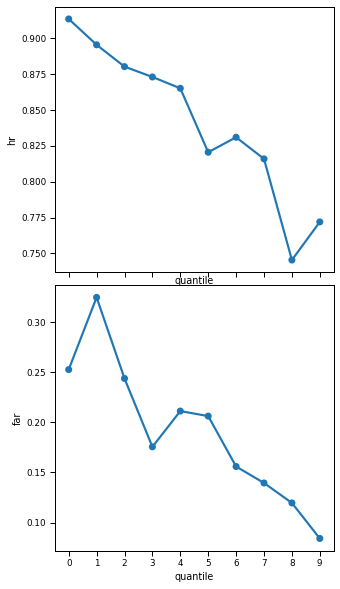

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,10))
fig.subplots_adjust(hspace=0.05)
# plt.xscale('log')

# ax1.set_ylim(0.78, 0.95)
# ax1.set_yticks([0.8,0.85,0.9,0.95])
# ax2.set_ylim(0.08, 0.23)
# ax2.set_yticks([0.1,0.15,0.2])
# plt.xlim(5, 14000)

sns.pointplot(data=df_quantgp, y='hr', x='quantile', ax=ax1)
sns.pointplot(data=df_quantgp, y='far', x='quantile', ax=ax2)

# plt.xlabel('Quantile')
# plt.ylabel('Hr')
plt.show()

<AxesSubplot:xlabel='csim', ylabel='Count'>

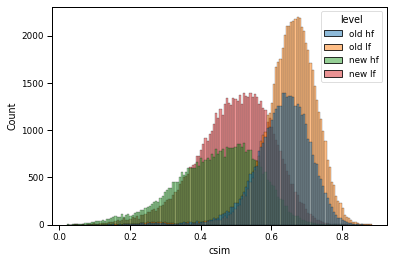

In [18]:
sns.histplot(data=df_simu, x="csim", hue = "level", palette = "tab10")

In [48]:
freq_order = df.sort_values(by="freq")['itemno'].to_numpy()

In [30]:
n = len(df)
smat_order = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        smat_order[i,j] = s_mat[freq_order[i],freq_order[j]]

In [31]:
smat_order

array([[ 1.        ,  0.2011113 ,  0.13239495, ..., -0.01074924,
         0.03020283,  0.21313739],
       [ 0.2011113 ,  1.        ,  0.08911801, ..., -0.0675719 ,
         0.08618007,  0.12869283],
       [ 0.13239495,  0.08911801,  1.        , ..., -0.01855728,
         0.10520838,  0.10746981],
       ...,
       [-0.01074924, -0.0675719 , -0.01855728, ...,  1.        ,
         0.09575007,  0.01251824],
       [ 0.03020283,  0.08618007,  0.10520838, ...,  0.09575007,
         1.        ,  0.14337983],
       [ 0.21313739,  0.12869283,  0.10746981, ...,  0.01251824,
         0.14337983,  1.        ]])

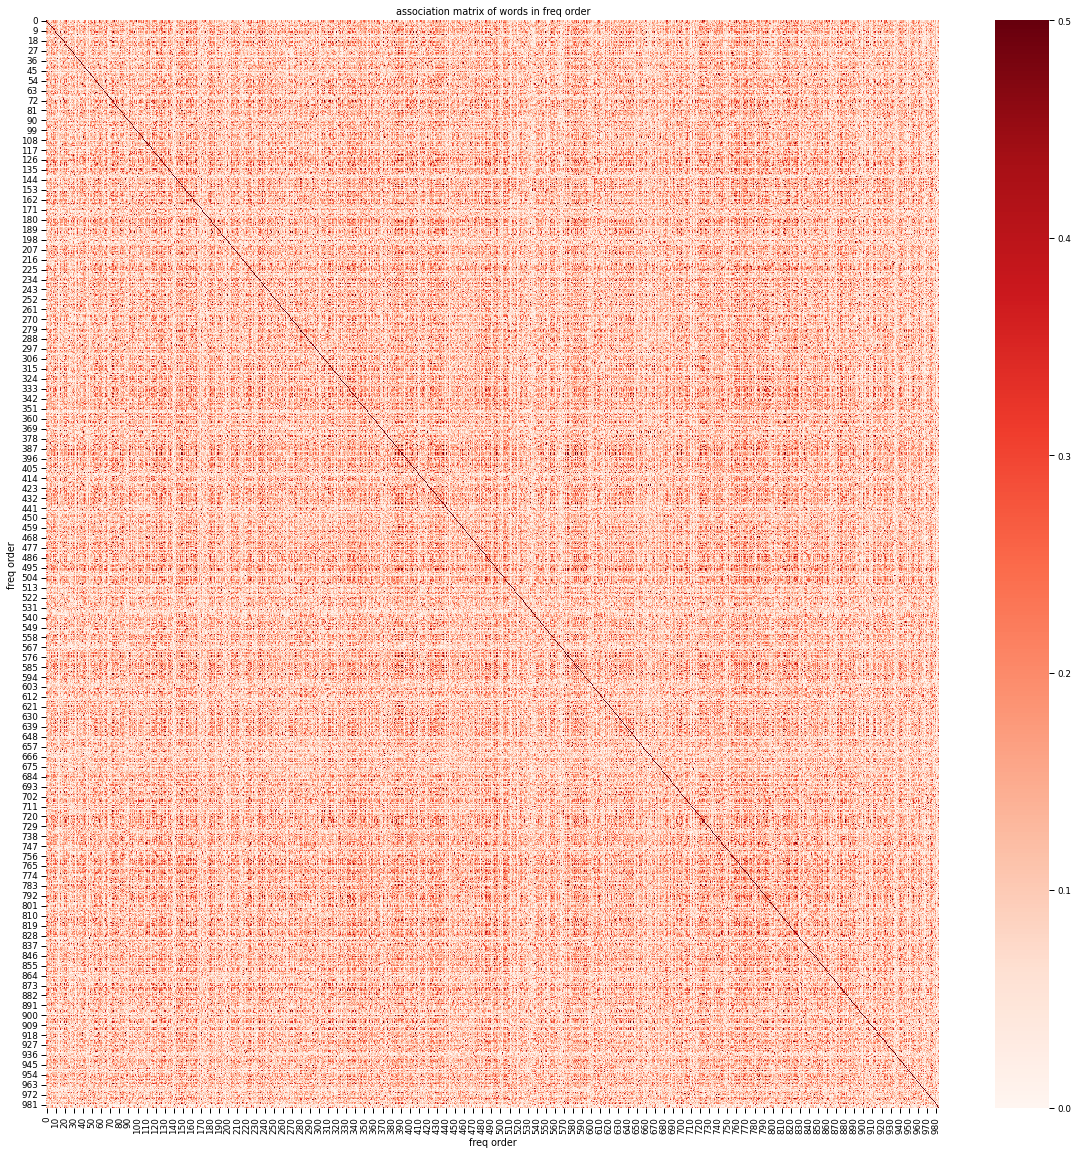

In [47]:
plt.subplots(figsize=(20,20))
sns.heatmap(smat_order,vmax = 0.5, vmin = 0, cmap = 'Reds')
plt.xlabel('freq order')
plt.ylabel('freq order')
plt.title("association matrix of words in freq order")
plt.show()